In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import glob
import xarray as xr
import sys
import os
sys.path.insert(1, '../Modules/')
from HW_detection_algorithm import *

In [2]:
### 1 SET-UP: Target temperature, HW definition and time period ###
var="tmax" #tmax,tmin

percent_thresh=90
duration_min=3

### TIME ###
clim_start=1993 #1981
clim_end=2016 #2010
period_start=1940
period_end=2022
if (period_end<clim_end) or (period_start>clim_start):
    raise Exception("Climatology period falls outside of target period")
years=[*range(period_start,period_end+1)]
climyears=[*range(clim_start,clim_end+1)]

nyear=len(years)
nclimyear=len(climyears)
nday=123 # days in period May to August
nrealisation=1 # ensemble members

In [3]:
# 2 LOCATION: Choose by longitude and latitude #

# e.g.
# LAKE COMO  #
# region="LakeComo"
#lon = '''9°5'0"E'''
#lat = '''45°49'0"N'''

# Cluj-Napoca #
region="Cluj-Napoca"
lon='''23°33'00"E'''
lat='''46°46'00"N'''

deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
latP= (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
deg, minutes, seconds, direction =  re.split('[°\'"]',lon)
lonP= (float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

# Find nearest ERA5 cell #
def find_nearest(array, value):
    #array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [4]:
# 3 DATA: Open/extract ERA5 temperature data #
#ds = xr.open_dataset(files[0])
#print (ds)

files=sorted(glob("/work/bk1318/b382634/ERA5/daily_REGRIDC3S/tmax/tmax_*_EUR_MJJA.nc")[period_start-1940:period_end+1-1940])
ds = xr.open_mfdataset(files, combine='by_coords')

lons=ds.lon.values
lats=ds.lat.values
ind_lon=np.argwhere(lons==find_nearest(lons,lonP))[0]
ind_lat=np.argwhere(lats==find_nearest(lats,latP))[0]
t_data=ds[var].values[:,ind_lat,ind_lon].reshape(nyear,nday,1)


In [5]:
# 4 HW DETECTION: Run HW detection algorithm #
HW_output=calc_HWMIyear(t_data, climyears, years, cross_valid = False, percent_thresh = percent_thresh, duration_min = duration_min, opt="polyfit")

In [6]:
# 5 SAVE: HW occurrence used for Feature Selection (go to Notebook #2) #

#dataset_out=xr.DataArray(np.sum(HW_output['HW_occurrence'],axis=1), dims=["year"], name="NumberHWDays")
#dataset_out.to_netcdf(f"Output/NumberHWdays_ERA5_{region}.nc")

# Calculate the sum along axis 1 (equivalent to the xarray operation)
hw_days = np.sum(HW_output['HW_occurrence'], axis=1)

# Create DataFrame with year index (assuming years start from some base year)
# You might need to adjust this based on your actual year range

df = pd.DataFrame({
    'year': years,
    'NumberHWDays': hw_days
})

# Create filename
filename = f"Output/NumberHWdays_ERA5_{region}.csv"

# Remove existing file if it exists
if os.path.exists(filename):
    os.remove(filename)

# Save to CSV
df.to_csv(filename, index=False)

print(f"Saved heat wave days data to {filename}")

Saved heat wave days data to Output/NumberHWdays_ERA5_Cluj-Napoca.csv


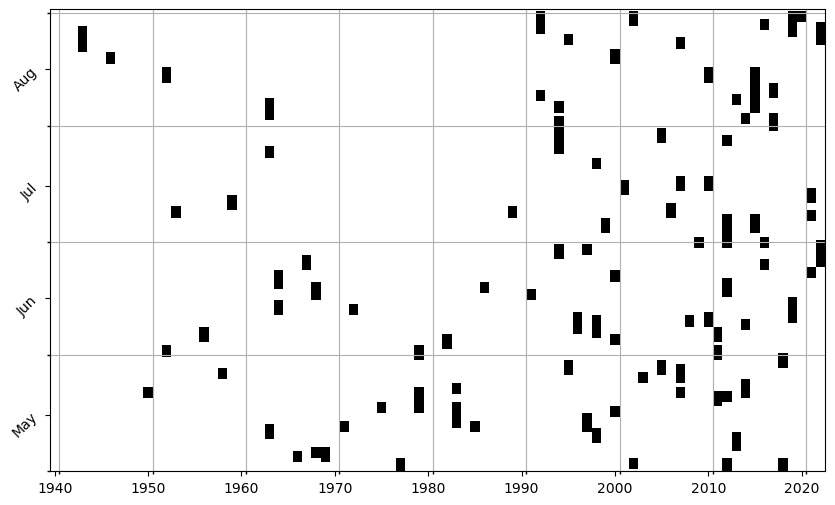

In [9]:
# 6 PLOTTING - optional #
# 6.1 2D TIME SERIES - HW OCCURRENCE #

fig,ax=plt.subplots(figsize=(10,6))

plt.pcolormesh(years,range(nday),HW_output['HW_occurrence'].T,cmap='binary')

plt.xticks(range(1940,2022,10))
plt.ylim([0,nday])
ticks=np.array([0,31,31+30,31+30+31])+15

plt.yticks(ticks,["May","Jun","Jul","Aug"],rotation=45)
ax.yaxis.set_minor_locator(FixedLocator(np.concatenate((ticks-15,np.array([31+30+31+30])))))
ax.xaxis.set_minor_locator(FixedLocator(np.arange(1940,2022,10)+0.5))
ax.tick_params(which='minor',width=1)

plt.plot([-1],[-1],'ks')

plt.xlim([1939.5,2022.5])
plt.grid(axis='y',which='minor')
plt.grid(axis='x',which='minor')
plt.show()

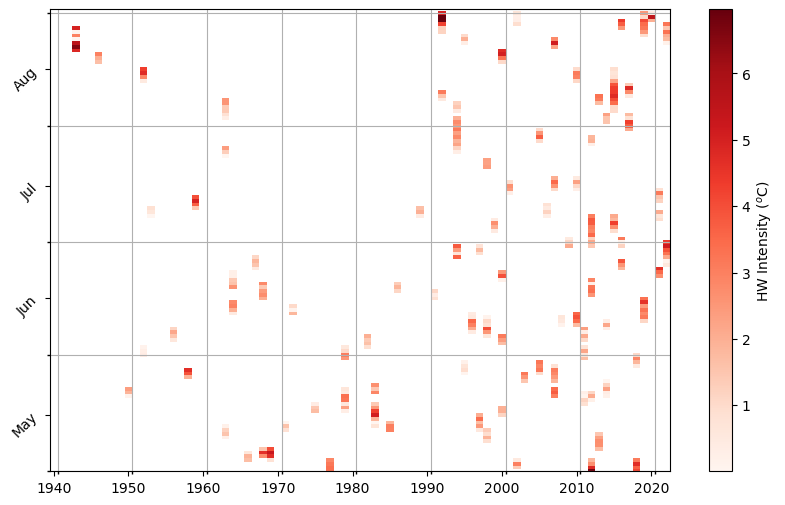

In [10]:
# 6.2 2D TIME SERIES - HW INTENSITY #

fig,ax=plt.subplots(figsize=(10,6))

plt.pcolormesh(years,range(nday),HW_output['HW_intensity_daily'].T,cmap='Reds')
plt.colorbar(label="HW Intensity ($^o$C)")
plt.xticks(range(1940,2022,10))
plt.ylim([0,nday])
ticks=np.array([0,31,31+30,31+30+31])+15

plt.yticks(ticks,["May","Jun","Jul","Aug"],rotation=45)
ax.yaxis.set_minor_locator(FixedLocator(np.concatenate((ticks-15,np.array([31+30+31+30])))))
ax.xaxis.set_minor_locator(FixedLocator(np.arange(1940,2022,10)+0.5))
ax.tick_params(which='minor',width=1)

plt.plot([-1],[-1],'ks')

plt.xlim([1939.5,2022.5])
plt.grid(axis='y',which='minor')
plt.grid(axis='x',which='minor')
plt.show()

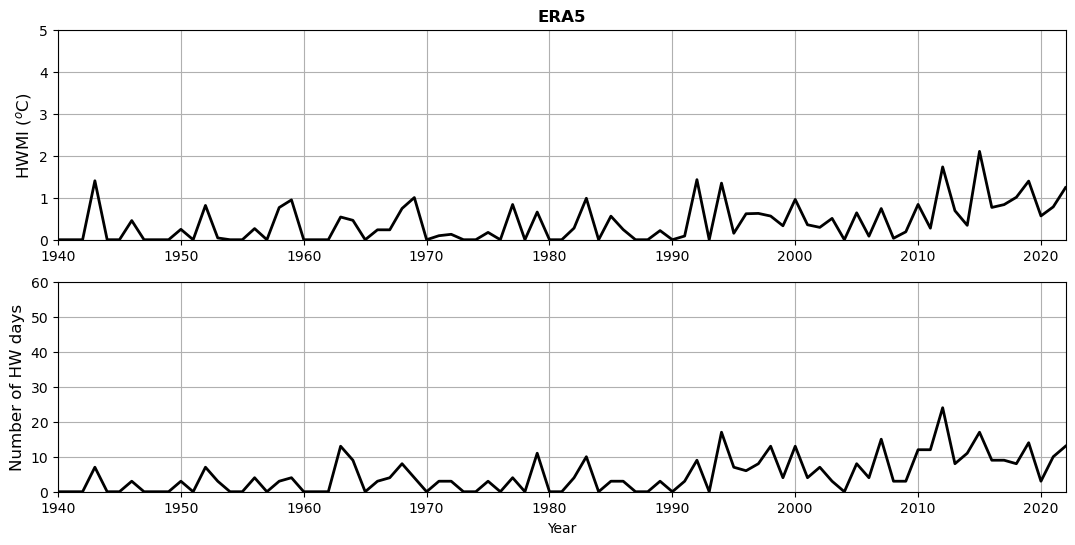

In [11]:
# 6.3 HWMI/Number of days (annual time series) #
fig, axs = plt.subplots(2, 1, figsize=(13, 6))

axs[0].set_title("ERA5", fontweight='bold')

axs[0].plot(years, HW_output['HWMI_year'], '-', lw=2, c='black',zorder=5)
axs[0].set_ylabel("HWMI ($^o$C)",fontsize=12)
axs[0].set_ylim([0,5])

axs[1].plot(years, np.sum(HW_output['HW_occurrence'],axis=1), '-', lw=2, c='black',zorder=5)
axs[1].set_ylabel("Number of HW days",fontsize=12)
axs[1].set_ylim([0,60])

axs[1].set_xlabel("Year")

for i in range(2):
    axs[i].set_xlim([1940,2022])
    axs[i].grid(zorder=1)

# Display the subplots
plt.show()

In [12]:
### EXTRACT HEATWAVE DATA FROM PALEO-CLIMATE SIMULATION ###

ds2 = xr.open_dataset("past2k_tasmax_HWs_EUR_MJJA_period70018850_clim88218850.nc", decode_times=False)

past2k_HWs=ds2['NDQ90_May'].values+ds2['NDQ90_Jun'].values+ds2['NDQ90_Jul'].values
print (past2k_HWs.shape)
lons=ds2.lon.values
lats=ds2.lat.values
ind_lon=int(np.argwhere(lons==find_nearest(lons,lonP))[0])
ind_lat=int(np.argwhere(lats==find_nearest(lats,latP))[0])
print (ind_lon, ind_lat)
past2k_HWs_target=past2k_HWs[:,0,ind_lat,ind_lon]
print (past2k_HWs_target.shape)
dataset_out=xr.DataArray(past2k_HWs_target, dims=["year"], name="NumberHWDays")
dataset_out.to_netcdf(f"NumberHWdays_past2k_{region}.nc")


# Create DataFrame with year index (assuming years start from some base year)
# You might need to adjust this based on your actual year range

df = pd.DataFrame({
    'year': range(0,1850,1),
    'NumberHWDays': past2k_HWs_target
})

# Create filename
filename = f"Output/NumberHWdays_past2k_{region}.csv"

# Remove existing file if it exists
if os.path.exists(filename):
    os.remove(filename)

# Save to CSV
df.to_csv(filename, index=False)

print(f"Saved heat wave days data to {filename}")


(1850, 1, 26, 41)
21 12
(1850,)
Saved heat wave days data to Output/NumberHWdays_past2k_Cluj-Napoca.csv


/tmp/ipykernel_2007285/3426657590.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind_lon=int(np.argwhere(lons==find_nearest(lons,lonP))[0])
/tmp/ipykernel_2007285/3426657590.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ind_lat=int(np.argwhere(lats==find_nearest(lats,latP))[0])


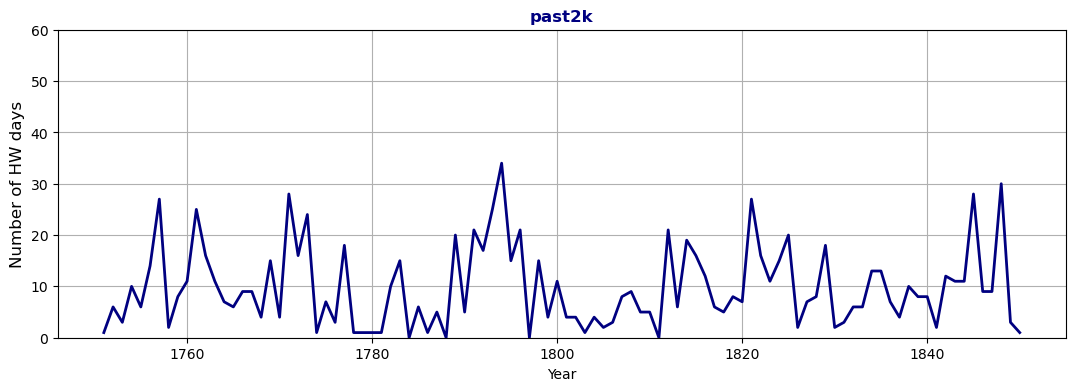

In [13]:
# 6.3 HWMI/Number of days (annual time series) #
fig, axs = plt.subplots(1, 1, figsize=(13, 4))

# Plot final 100 years of 1850-year dataset
axs.plot(np.arange(1751,1851,1), past2k_HWs_target[-100:], ls='-', lw=2, c='navy',zorder=5)
axs.set_ylabel("Number of HW days",fontsize=12)
axs.set_ylim([0,60])

axs.set_xlabel("Year")

#axs.set_xlim([1940,2022])
axs.grid(zorder=1)
axs.set_title("past2k", fontweight='bold', color='navy')

plt.show()